## Figure 6
###  Top 10 most frequent connections in each meter placed on the timeline

In [1]:
library(tidyverse)
#library(tidytext)

#library(igraph)
#library(ggraph)

theme_set(theme_minimal())
library(wesanderson)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [5]:
# load data
load("../data/lda75_output.Rda")

# load code for edges calculation
source("03_fn_calculate_edges.R")

# function to extract topic lables:
get_topic_labels = function(x, n_labels = 10) {
  
  #takes beta-matrix as an input
  top_terms = x %>%
    group_by(topic) %>%
    top_n(20, beta) %>%
    ungroup() %>%
    arrange(topic, -beta)
  
  topic_labels = top_terms %>%
    group_by(topic) %>%
    top_n(n_labels, beta) %>%
    summarise(label=paste(term, collapse=" ")) %>%
    mutate(label = paste(topic, label, sep="_"))
  
  return(topic_labels)
}

topic_labels <- get_topic_labels(beta, n_labels = 5)

# prepare gamma data
gamma <- gamma %>% 
    # select ONLY RNC connections & topics
    filter(corpus == "N") %>% 
    # add index for create_edges function
    mutate(index = paste0(corpus, "_", id)) %>% 
    # fix typo
    rename(author = first_line)

# create edges
edges_raw <- compute_edges(gamma,
                           gamma_thresh = 0.05,
                           time_slice = 5)

# select only RNC edges
edges <- edges_raw %>% 
    filter(corpus == "N") %>% 
    rename(meter = formula) %>% 
    filter(slice != 1850) %>% 
    filter(meter %in% c("iamb_4", "iamb_free", "iamb_6", 
                        "trochee_4"))

In [6]:
# create a named vector for facet labels
meter_labels <- setNames(c("Iamb-4", "Iamb free", "Iambic hexameter", "Trochaic tetrameter"),
                         c("iamb_4", "iamb_free", "iamb_6", "trochee_4"))
meter_labels

iamb_4             iamb_free                iamb_6 
             "Iamb-4"           "Iamb free"    "Iambic hexameter" 
            trochee_4 
"Trochaic tetrameter"

In [7]:
# calculate connections
c_count <- edges %>% 
  select(meter, slice, edge_id) %>% 
  group_by(edge_id,meter) %>% 
  # frequency filtering
  mutate(n_times = row_number()) %>% 
  distinct(slice, edge_id)

top_connections <- c_count %>%
  group_by(meter, edge_id) %>% 
  count() %>% 
  group_by(meter) %>% 
  top_n(10) %>% mutate(is_top = T)

head(c_count)
head(top_connections)

Adding missing grouping variables: `index`
Selecting by n


meter,slice,edge_id
<chr>,<dbl>,<chr>
iamb_free,1810,1 46
trochee_4,1830,1 42
trochee_4,1830,1 53
trochee_4,1830,1 61
trochee_4,1835,1 18
trochee_4,1835,1 26


meter,edge_id,n,is_top
<chr>,<chr>,<int>,<lgl>
iamb_4,19 50,13,TRUE
iamb_4,21 24,14,TRUE
iamb_4,21 33,13,TRUE
iamb_4,21 74,13,TRUE
iamb_4,26 66,14,TRUE
iamb_4,5 31,13,TRUE


Joining with `by = join_by(meter, edge_id)`


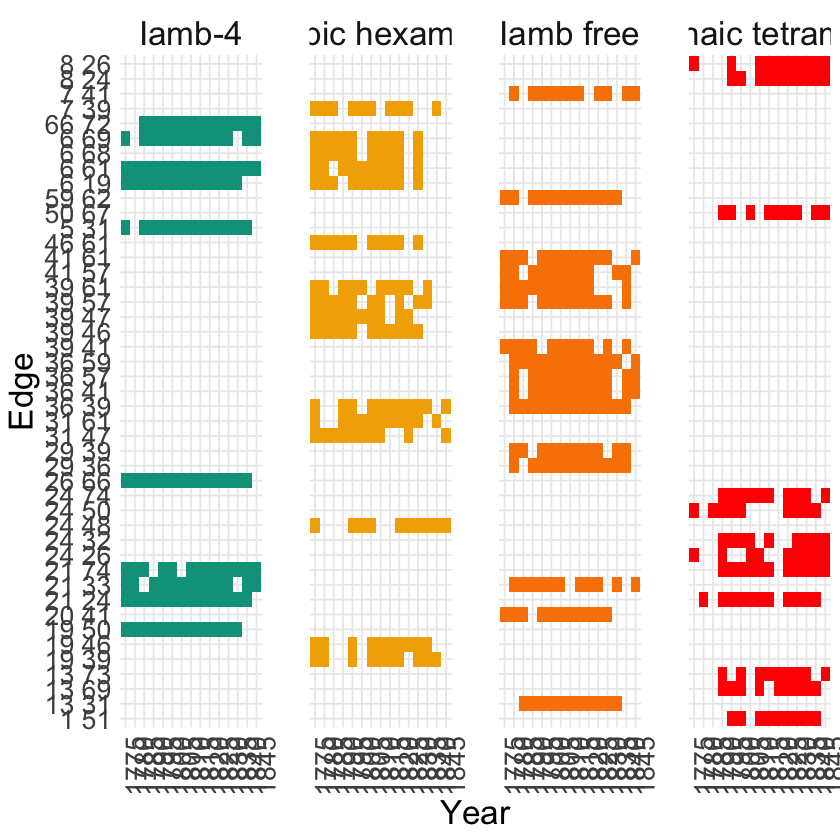

In [17]:
# create plot
c_count %>% 
    left_join(top_connections) %>% 
    filter(is_top) %>% 
    filter(slice < 1850) %>% 
    ggplot(aes(x = factor(slice), y = edge_id, fill = meter)) + 
    geom_tile() + 
    scale_fill_manual(values = c(wes_palette("Darjeeling1")[2],
                                 wes_palette("Darjeeling1")[3],
                                 wes_palette("Darjeeling1")[4],
                                 wes_palette("Darjeeling1")[1])) + 
    theme(axis.text.x = element_text(angle = 90),
          plot.title = element_text(hjust = 0.5), 
          axis.text = element_text(size = 16),
          axis.title = element_text(size = 20),
          legend.position = "None",
          strip.text = element_text(size = 20),
          panel.spacing = unit(1, "cm")
         ) + 
    labs(
        x = "Year", 
        y = "Edge",
        fill = "Meter") + 
    facet_wrap(~meter, 
               ncol = 4,
               labeller = as_labeller(meter_labels)
              )

In [19]:
ggsave(file = "../plots/Fig_6.png",
      plot = last_plot(),
      width = 16, height = 10,
      dpi = 300, bg = "white")